### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.special import factorial
from landaupy import landau
from scipy.special import factorial
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import array
from collections import Counter
import daw_readout
from matplotlib.colors import LogNorm
from tqdm import trange
from tqdm import tqdm
import time  
import os 

np.set_printoptions(suppress=True) # to make tiny values appear as zero
np.set_printoptions(precision=4)   # number of digits in floats (or longfloats)
#np.set_printoptions(formatter={'float_kind':"{:.2f}"})
#np.set_printoptions()

%matplotlib inline

# Set formats
DARK=False
if(DARK==False):
    form='.k'
    plt.style.use(['default']) 
    fontcolor='k'
else:
    form='.w'
    plt.style.use(['dark_background'])
    fontcolor='w'


SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {
    'font.family': 'serif',
    'font.size' : 16, 'axes.titlesize' : 16, 'axes.labelsize' : 16, 'axes.linewidth' : 1,
    # ticks
    'xtick.labelsize' : 16, 'ytick.labelsize' : 16, 'xtick.major.size' : 8, 'xtick.minor.size' : 4,
    'ytick.major.size' : 8, 'ytick.minor.size' : 4, 'xtick.major.width' : 1, 'xtick.minor.width' : 1,
    'ytick.major.width' : 1, 'ytick.minor.width' : 1, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 4, 'lines.markeredgewidth' : 1, 'errorbar.capsize' : 5, 'lines.linewidth' : 1.5,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 16,
    'axes.labelsize': 16, 'axes.titlesize':20, 'xtick.labelsize':16, 'ytick.labelsize':16,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':8,
    # ticks
    'xtick.major.pad': 7,   'xtick.minor.pad': 7,   
    'ytick.major.pad': 4, 'ytick.minor.pad': 4,
}
plt.rcParams.update(params)

### Processing Data

In [2]:
Date = 20241017 # YYYYMMDD
V = 2 # V
offset = 900 # mV
T = 1000 # ns
PDiv = 9 # dB

name = "lv2415_anode_lv2414_dual_20241017_LED_2v_900mv_1us_attenuator_9DB_run0"

calbl = 10 ### Length used to calculate baseline
calstart = 95 ### Index started to calculate area
callen= 300 ### Length used to calculate area

In [3]:
path = "/mnt/data/PMT/R8520_406/"   ##### file path

filesnum = 1 ### number of files

hdf5_filename = path + name + ".h5"
feather_filename = path + name + ".feather"
filename = {}
filepath = {}
dataload = {}
for i in range(filesnum):
    filename[i] = name + "_raw_b0_seg" + str(i) +".bin"
    filepath[i] = path + filename[i]
    dataload[i] = daw_readout.DAWDemoWaveParser(filepath[i])

#name_3 = 'run_gamma_$(date_raw_b0_seg0.bin'

### Background data
#data0 = daw_readout.DAWDemoWaveParser([path+name[0]])#### background data

data = []

for num in range(filesnum):
# Process the waveforms and store the data in lists
    i = 0
    for wave in tqdm(dataload[num]):
        baseline2 = np.sum(wave.Waveform[:calbl]) / calbl
        area = (baseline2 * callen - np.sum(wave.Waveform[calstart : calstart+callen]))
        height = (baseline2 - np.min(wave.Waveform[calstart : calstart+callen]))
        data.append({
            'Files': num,   ####file name/number
            'EventID': i,   ####index in file
            'Channel': wave.Channel, #### PMT Channel
            'Timestamp': wave.Timestamp, 
            'Baseline': wave.Baseline,
            'Baseline2': baseline2,
            'Height': height,
            'Area': area,
            'AtH':area/height,
            'Waveform':wave.Waveform
            })
        i += 1

# Convert lists to pandas DataFrames
df = pd.DataFrame(data)

# Print the total number of events for each channel
print("CH0 Total Events:",len(df.EventID[df.Channel==0]))
print("CH1 Total Events:",len(df.EventID[df.Channel==1]))

ch1_area_0 = []
ch0_area_0 = []
ch2_area_0 = []

ch0_area = []
ch1_area = []
ch2_area = []

area_ratio = []

for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area.append(df.Area[i]/96.99)
    elif df.Channel[i] == 0:
        ch0_area.append(df.Area[i]/77.79)
    elif df.Channel[i] == 2:
        ch2_area.append(-df.Area[i]/77.79)

"""
for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area_0.append(df.Area[i])
    elif df.Channel[i] == 0:
        ch0_area_0.append(df.Area[i])

for i in tqdm(range(0,len(ch0_area_0))):
    if ch1_area_0[i] > 60:
        ch0_area.append(ch0_area_0[i])
        ch1_area.append(ch1_area_0[i])
"""

for i in tqdm(range(0,len(ch0_area))):
    if ch1_area[i] != 0:
        area_ratio.append(ch0_area[i]/ch1_area[i])
    else:
        area_ratio.append(0)

380706it [00:03, 96971.24it/s] 


CH0 Total Events: 126902
CH1 Total Events: 126902


100%|██████████| 126902/126902 [00:00<00:00, 4023810.02it/s]


In [5]:
# Area ratio
with open('tau_saturation.txt', 'a') as f:
    print(V,T,round(np.mean(ch0_area),2),round(np.std(ch0_area),2),round(np.mean(ch1_area),2),round(np.std(ch1_area),2),
          PDiv,Date,round(np.mean(ch2_area),2),round(np.std(ch2_area),2), file=f)

In [4]:
df[:]

,Files,EventID,Channel,Timestamp,Baseline,Baseline2,Height,Area,AtH,Waveform
0,0,0,0,175172,15172,15172.6,4201.6,637059.0,151.622953,"[15173, 15173, 15173, 15173, 15173, 15170, 151..."
1,0,1,1,175172,15327,15327.6,7410.6,1277119.0,172.336788,"[15330, 15327, 15330, 15330, 15321, 15324, 153..."
2,0,2,2,175172,8114,8113.0,11.0,-290511.0,-26410.090909,"[8111, 8113, 8114, 8113, 8116, 8112, 8110, 811..."
3,0,3,0,425168,15172,15172.0,4193.0,637090.0,151.941331,"[15173, 15167, 15175, 15172, 15172, 15171, 151..."
4,0,4,1,425168,15327,15328.4,7585.4,1278130.0,168.498695,"[15329, 15327, 15326, 15329, 15326, 15328, 153..."
...,...,...,...,...,...,...,...,...,...,...
380701,0,380701,2,31724962784,8112,8112.7,9.7,-290020.0,-29898.969072,"[8116, 8113, 8112, 8113, 8109, 8112, 8112, 811..."
380702,0,380702,0,31724962784,15170,15171.4,4202.4,637105.0,151.605035,"[15174, 15167, 15174, 15170, 15175, 15171, 151..."
380703,0,380703,0,31725212784,15170,15171.1,4188.1,637134.0,152.129605,"[15167, 15172, 15171, 15171, 15171, 15174, 151..."
380704,0,380704,1,31725212784,15325,15325.9,7534.9,1279084.0,169.754609,"[15326, 15328, 15324, 15328, 15326, 15323, 153..."


### Checking waveform

100%|██████████| 200/200 [00:00<00:00, 1369.26it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


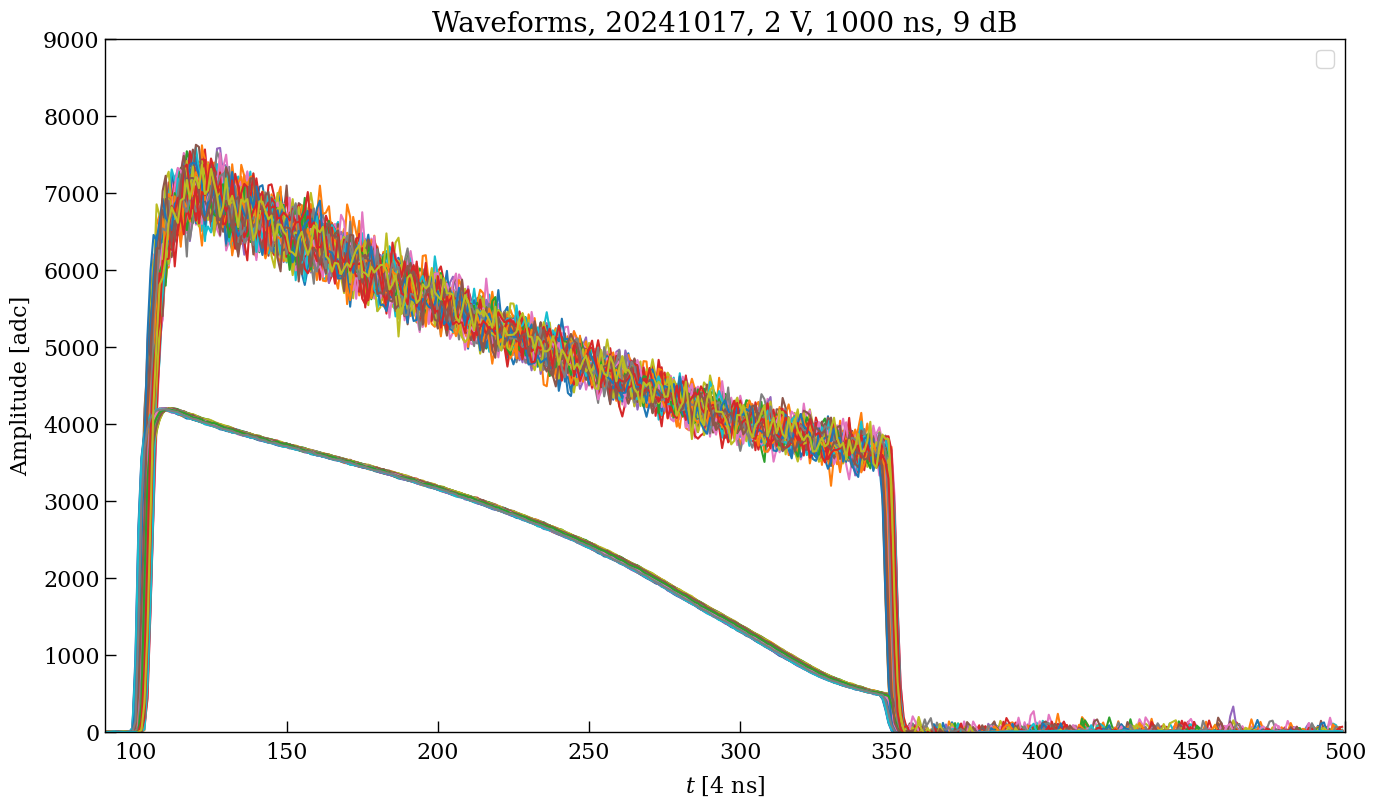

In [21]:
plt.figure(figsize=(16,9))
plt.title('Waveforms, '+str(Date)+', '+str(V)+' V, '+str(T)+' ns, '+str(PDiv)+' dB')
plt.xlabel('$t$ [4 ns]')
plt.ylabel('Amplitude [adc]')
plt.xlim(90,500)
plt.ylim(0,9000)
for i in tqdm(range (0,200)):
    #plt.step(np.linspace(0,150,150),df.Baseline[i]-df.Waveform[i])
    plt.plot(df.Baseline[i]-df.Waveform[i])
plt.legend()
plt.show()

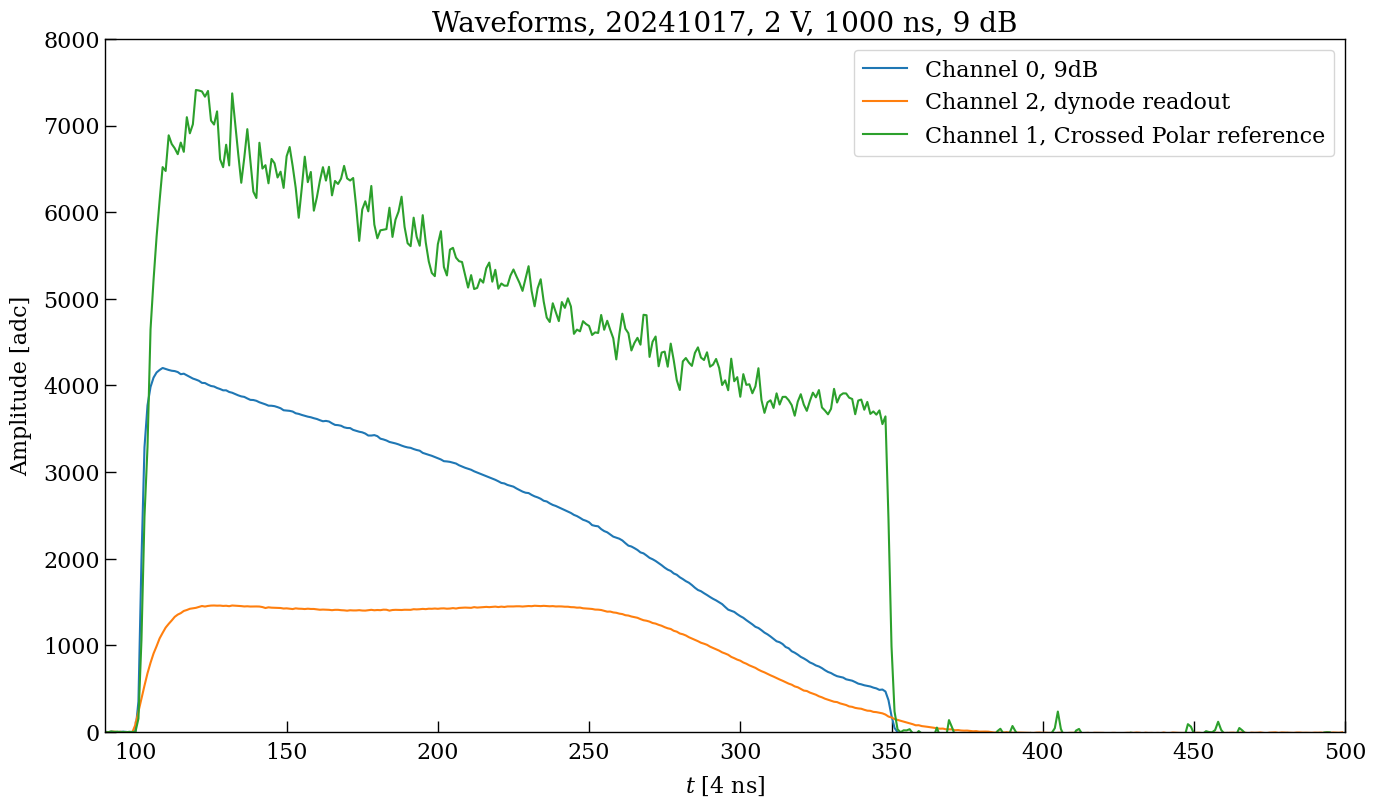

In [18]:
plt.figure(figsize=(16,9))
plt.title('Waveforms, '+str(Date)+', '+str(V)+' V, '+str(T)+' ns, '+str(PDiv)+' dB')
plt.xlabel('$t$ [4 ns]')
plt.ylabel('Amplitude [adc]')
plt.xlim(90,500)
plt.ylim(0,8000)
plt.plot(df.Baseline[0]-df.Waveform[0],label = "Channel 0, 9dB")
plt.plot(-df.Baseline[2]+df.Waveform[2],label="Channel 2, dynode readout")
plt.plot(df.Baseline[1]-df.Waveform[1],label = "Channel 1, Crossed Polar reference")
plt.legend()
plt.show()

### FFT of the waveform

In [35]:
Amplitude = df.Baseline[0]-df.Waveform[0]

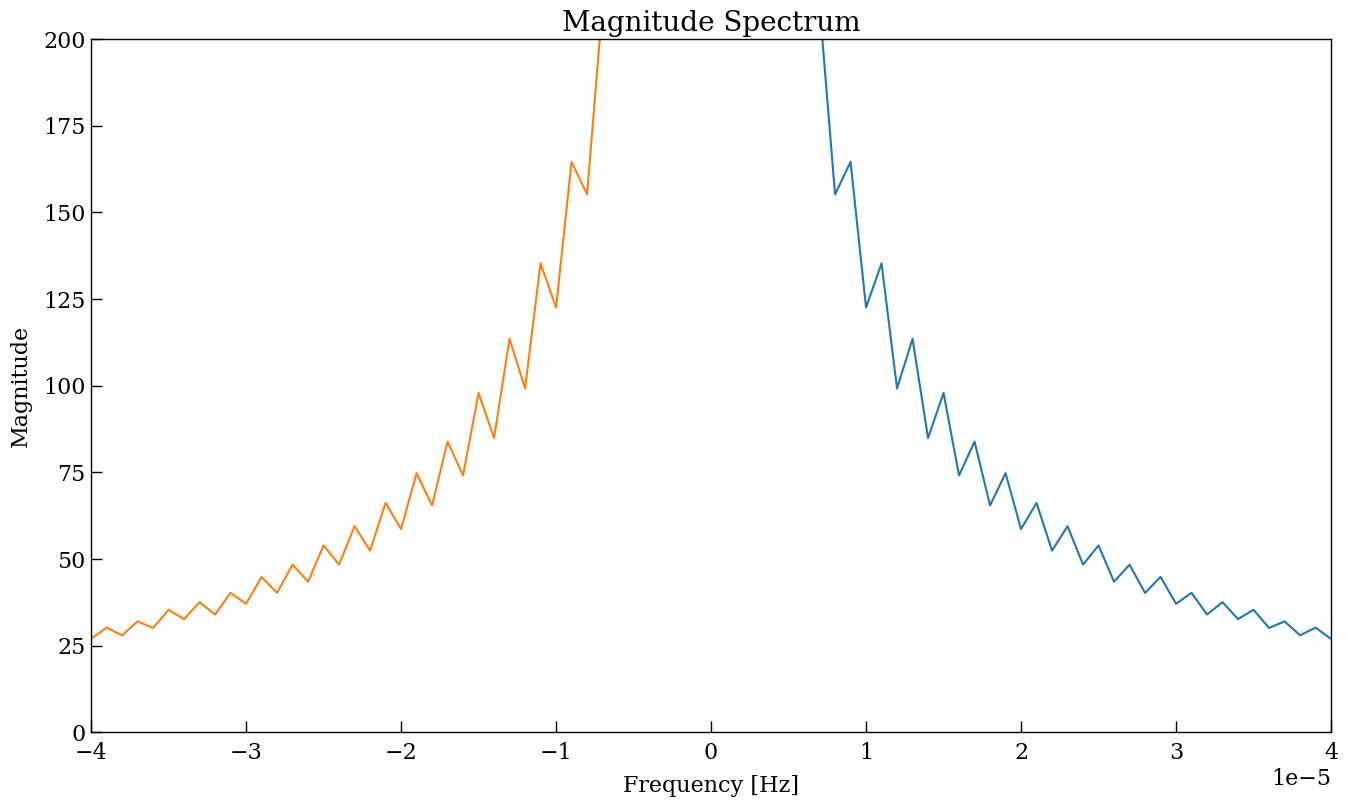

In [56]:
# Compute the FFT
fft_result = np.fft.fft(Amplitude)

Number = len(Amplitude)
frequencies = np.fft.fftfreq(Number, 4*Number)
frequencies_negative = (-1) * frequencies

# Plot the magnitude spectrum
plt.figure(figsize=(16, 9))
plt.plot(frequencies[:Number//2], np.abs(fft_result)[:Number//2] * (1.0 / (Number//2)))  # Normalization
plt.plot(frequencies_negative[:Number//2], np.abs(fft_result)[:Number//2] * (1.0 / (Number//2)))  # Normalization
plt.title('Magnitude Spectrum')
plt.xlim(-0.00004,0.00004)
plt.ylim(0,200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

### Fitting waveform